In [ ]:
!apt-get install -y libosmesa6-dev patchelf
!pip install gymnasium[mujoco] imageio[ffmpeg] pyopengl glfw -qU

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
patchelf is already the newest version (0.14.3-1).
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"
import gymnasium as gym
import numpy as np
from math import sqrt
from scipy.stats import t
from scipy.stats import ttest_ind_from_stats
import matplotlib.pyplot as plt
import math
import random
import glob
import time
from google.colab import files
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [ ]:
def make_env(env_id, seed, idx, capture_video, xml=None):
    def thunk():
        if xml is not None:
          if capture_video and idx == 0:
              env = gym.make(env_id, xml_file=xml , render_mode="rgb_array")
          else:
              env = gym.make(env_id, xml_file=xml)
        else:
          if capture_video and idx == 0:
              env = gym.make(env_id, render_mode="rgb_array")
          else:
              env = gym.make(env_id)

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk


LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))

        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.single_action_space.high - env.single_action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.single_action_space.high + env.single_action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

In [ ]:
from gymnasium.envs.mujoco.ant_v5 import AntEnv
from gymnasium.spaces import Box
from gymnasium.envs.registration import register

class ThreeLegAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.action_space = Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)

register(
    id="3LegAnt",
    entry_point=ThreeLegAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class FiveLegAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.action_space = Box(low=-1.0, high=1.0, shape=(10,), dtype=np.float32)

register(
    id="5LegAnt",
    entry_point=FiveLegAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class HopperAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

register(
    id="HopperAnt",
    entry_point=HopperAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class LongShortAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

register(
    id="LongShortAnt",
    entry_point=LongShortAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class ShortLongAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

register(
    id="ShortLongAnt",
    entry_point=ShortLongAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class ClimberAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self._forward_reward_weight = 0.3
    self._healthy_z_range = (0.2, 1.6)
  def _get_rew(self, x_velocity: float, action):
      to_x_reward = 0
      if x_velocity > 0.3:
        to_x_reward = 2
      forward_reward = (x_velocity * self._forward_reward_weight) + to_x_reward
      healthy_reward = self.healthy_reward
      rewards = forward_reward + healthy_reward

      ctrl_cost = self.control_cost(action)
      contact_cost = self.contact_cost
      costs = ctrl_cost + contact_cost

      reward = rewards - costs

      reward_info = {
          "reward_forward": forward_reward,
          "reward_ctrl": -ctrl_cost,
          "reward_contact": -contact_cost,
          "reward_survive": healthy_reward,
      }

      return reward, reward_info

register(
    id="ClimberAnt",
    entry_point=ClimberAntEnv,
    max_episode_steps=1200,
    reward_threshold=5000.0,
)

class GoAroundAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self._forward_reward_weight = 0.3
  def _get_rew(self, x_velocity: float, action):
      to_x_reward = 0
      if x_velocity > 0.3:
        to_x_reward = 2
      forward_reward = (x_velocity * self._forward_reward_weight) + to_x_reward
      healthy_reward = self.healthy_reward
      rewards = forward_reward + healthy_reward

      ctrl_cost = self.control_cost(action)
      contact_cost = self.contact_cost
      costs = ctrl_cost + contact_cost

      reward = rewards - costs

      reward_info = {
          "reward_forward": forward_reward,
          "reward_ctrl": -ctrl_cost,
          "reward_contact": -contact_cost,
          "reward_survive": healthy_reward,
      }

      return reward, reward_info


register(
    id="GoAroundAnt",
    entry_point=GoAroundAntEnv,
    max_episode_steps=1200,
    reward_threshold=5000.0,
)

In [ ]:
def evaluate( models: list, env_id: str, eval_episodes: int,
              device: torch.device = torch.device("cpu"),
              seed = 0, env_xml = None,
            ):

    episodic_returns = []
    for model_path in models:
      envs = gym.vector.SyncVectorEnv([make_env(env_id, seed, 0, capture_video=False, xml=env_xml)])
      actor = Actor(envs).to(device)
      if model_path is not None:
        actor.load_state_dict(torch.load(model_path, map_location=device))
      actor.eval()

      episode_return = 0.0
      obs, _ = envs.reset()
      episode=0
      while episode < eval_episodes:
          actions, _, _ = actor.get_action(torch.Tensor(obs).to(device))
          obs, rewards, done, truncated, _ = envs.step(actions.detach().cpu().numpy())
          dones = np.logical_or(done, truncated)
          episode_return += rewards[0]
          if dones[0]:
              episode += 1
              episodic_returns.append(episode_return)
              episode_return = 0.0

    return episodic_returns

def compute_stats(returns):
    mean = np.mean(returns)
    std = np.std(returns)
    print(f"Mean: {mean}, Std: {std}")
    return mean, std

def plot_grouped_barcharts(results):
    base_mean, base_std = results["BaseAnt"]["BaseAnt"]
    untrained_mean, untrained_std = results["BaseAnt"]["Untrained"]

    for variant, data in results.items():
        if variant == "BaseAnt":
            continue

        labels = []
        means = []
        stds = []

        labels.append("Untrained")
        means.append(untrained_mean)
        stds.append(untrained_std)

        labels.append("Base")
        means.append(base_mean)
        stds.append(base_std)

        for label in data:
            mean, std = data[label]
            labels.append(label)
            means.append(mean)
            stds.append(std)

        plt.figure(figsize=(8, 5))
        x = np.arange(len(labels)) * 0.25
        bars = plt.bar(x, means, yerr=stds, capsize=5, width=0.2)
        plt.xticks(x, labels, rotation=30, ha="right")
        plt.ylabel("Mean & Std Episodic Returns")
        plt.title(f"Evaluation Results for {variant}")
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        import matplotlib.patches as mpatches
        import matplotlib.lines as mlines

        bar_patch = mpatches.Patch(color=bars[0].get_facecolor(), label='Mean Return')
        error_line = mlines.Line2D([], [], color='black', marker='_', linestyle='None',
                                   markersize=10, label='± 1 Std Dev')

        plt.legend(handles=[bar_patch, error_line], loc='upper left', fontsize=9)

        filename = f"{variant}_results.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

        files.download(filename)

Mean: 644.8153142339935, Std: 188.27885484893034
Mean: 5607.196554604944, Std: 650.9554476428688
Mean: -195.77167668423786, Std: 474.52542022728335
Mean: 3254.678907139204, Std: 1190.6897025121216
Mean: 2985.760778561784, Std: 1373.649249596081
Mean: 3878.9605011939652, Std: 1438.6084620387608
Mean: 4007.0176563758555, Std: 1167.4002772423753


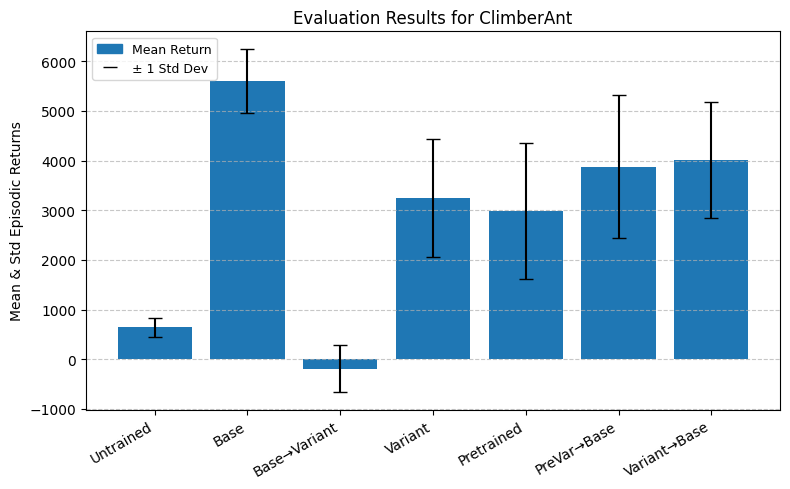

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Ants
BaseAnt="Ant-v5"
BaseAnt_model=["/content/1_Ant_ExpBase_SAC_actor.pth"]

ClimberAnt = "ClimberAnt"
ClimberAnt_xml="/content/ClimberAnt.xml"
Climber_models=["/content/1_Climber_Base_1_actor.pth",
                "/content/2_Climber_Base_2_actor.pth",
                "/content/3_Climber_Base_3_actor.pth",
                "/content/4_Climber_Base_4_actor.pth",
                "/content/5_Climber_Base_5_actor.pth",
                ]
Pretrain_Climber_models=["/content/None_Climber_EXP_1_actor.pth",
                         "/content/None_Climber_EXP_2_actor.pth",
                         "/content/None_Climber_EXP_3_actor.pth",
                         "/content/None_Climber_EXP_4_actor.pth",
                         "/content/None_Climber_EXP_5_actor.pth",
                         ]

HopperAnt = "HopperAnt"
HopperAnt_xml="/content/HopperAnt.xml"
Hopper_model1=["/content/1_Hopper_Base_1_actor.pth"]
Hopper_model2=["/content/2_Hopper_Base_2_actor.pth"]
Pretrain_Hopper_model1=["/content/1_Hopper_EXP_1_actor.pth"]
Pretrain_Hopper_model2=["/content/2_Hopper_EXP_2_actor.pth"]

ShortLongAnt = "ShortLongAnt"
ShortLongAnt_xml="/content/ShortLongAnt.xml"
ShortLong_models=["/content/1_ShortLong_Base_1_actor.pth",
                  "/content/2_ShortLong_Base_2_actor.pth",
                  "/content/3_ShortLong_Base_3_actor.pth",
                  "/content/4_ShortLong_Base_4_actor.pth",
                  "/content/5_ShortLong_Base_5_actor.pth",
                  ]
Pretrain_ShortLong_models=["/content/1_ShortLong_EXP_1_actor.pth",
                           "/content/2_ShortLong_EXP_2_actor.pth",
                           "/content/3_ShortLong_EXP_3_actor.pth",
                           "/content/4_ShortLong_EXP_4_actor.pth",
                           "/content/5_ShortLong_EXP_5_actor.pth",
                           ]

GoAroundAnt = "GoAroundAnt"
GoAroundAnt_xml="/content/GoAroundAnt.xml"
GoAround_models=["/content/1_GoAround_Base_1_actor.pth",
                  "/content/2_GoAround_Base_2_actor.pth",
                  "/content/3_GoAround_Base_3_actor.pth",
                  "/content/4_GoAround_Base_4_actor.pth",
                  "/content/5_GoAround_Base_5_actor.pth",
                  ]
Pretrain_GoAround_models=["/content/1_GoAround_EXP_1_actor.pth",
                           "/content/2_GoAround_EXP_2_actor.pth",
                           "/content/3_GoAround_EXP_3_actor.pth",
                           "/content/4_GoAround_EXP_4_actor.pth",
                           "/content/5_GoAround_EXP_5_actor.pth",
                           ]



episodes=100


'''Untrained model run on BaseAnt Env'''
Untrained_returns = evaluate(models=[None], env_id=BaseAnt, eval_episodes=episodes)
'''BaseAnt model Eval'''
BaseAnt_returns = evaluate(models=BaseAnt_model, env_id=BaseAnt, eval_episodes=episodes)

#Climber
'''BaseAnt model run on ClimberAnt Env'''
BaseToClimber_returns = evaluate(models=BaseAnt_model, env_id=ClimberAnt, eval_episodes=episodes, env_xml=ClimberAnt_xml)

'''ClimberAnt model Eval'''
ClimberAnt_returns = evaluate(models=Climber_models, env_id=ClimberAnt, eval_episodes=episodes, env_xml=ClimberAnt_xml)
'''Pretrained ClimberAnt model Eval'''
Pretrain_ClimberAnt_returns = evaluate(models=Pretrain_Climber_models, env_id=ClimberAnt, eval_episodes=episodes, env_xml=ClimberAnt_xml)
'''Pretrained ClimberAnt model run on BaseAnt Env'''
Pretrain_ClimberToBase_returns = evaluate(models=Pretrain_Climber_models, env_id=BaseAnt, eval_episodes=episodes)
'''ClimberAnt model run on BaseAnt Env'''
ClimberToBase_returns = evaluate(models=Climber_models, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "ClimberAnt": {
        "Base→Variant": compute_stats(BaseToClimber_returns),
        "Variant": compute_stats(ClimberAnt_returns),
        "Pretrained": compute_stats(Pretrain_ClimberAnt_returns),
        "PreVar→Base": compute_stats(Pretrain_ClimberToBase_returns),
        "Variant→Base": compute_stats(ClimberToBase_returns),
    }
}

plot_grouped_barcharts(results)

Mean: 644.8153142339935, Std: 188.27885484893034
Mean: 5607.196554604944, Std: 650.9554476428688
Mean: -199.36408428753606, Std: 347.70312819524594
Mean: 2887.3488067836706, Std: 696.4970297457514
Mean: 3090.1556346272596, Std: 903.0034508401594
Mean: 3268.6937276584013, Std: 905.1987079158621
Mean: 927.75605086323, Std: 3.3250765028620934
Mean: 36.6386570016439, Std: 160.65496517442028
Mean: 547.0029951821914, Std: 8.389787346749058
Mean: 43.17240667484852, Std: 196.40916767105148
Mean: -932.7283922609013, Std: 304.5513566576738


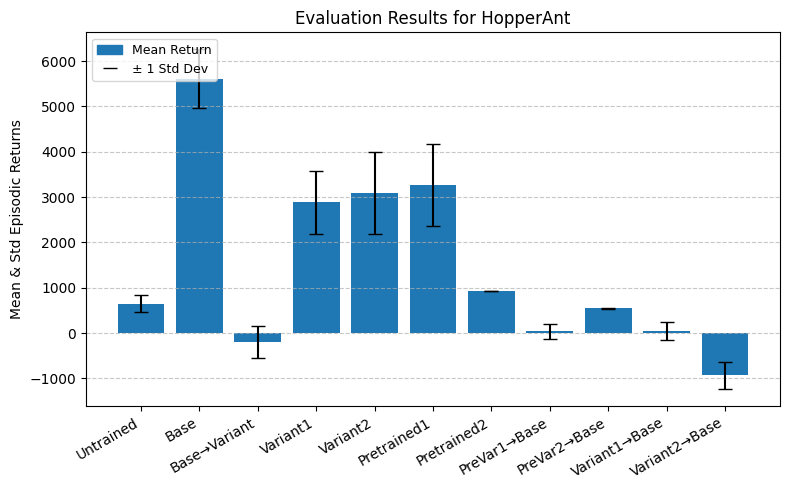

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Hopper best and worst models.
'''BaseAnt model run on HopperAnt Env'''
BaseToHopper_returns = evaluate(models=BaseAnt_model, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''HopperAnt model1 Eval'''
HopperAnt1_returns = evaluate(models=Hopper_model1, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''HopperAnt model2 Eval'''
HopperAnt2_returns = evaluate(models=Hopper_model2, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''Pretrained HopperAnt model1 Eval'''
Pretrain_HopperAnt1_returns = evaluate(models=Pretrain_Hopper_model1, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''Pretrained HopperAnt model2 Eval'''
Pretrain_HopperAnt2_returns = evaluate(models=Pretrain_Hopper_model2, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''Pretrained HopperAnt model1 run on BaseAnt Env'''
PreHopToBase1_returns = evaluate(models=Pretrain_Hopper_model1, env_id=HopperAnt, eval_episodes=episodes)
'''Pretrained HopperAnt model2 run on BaseAnt Env'''
PreHopToBase2_returns = evaluate(models=Pretrain_Hopper_model2, env_id=HopperAnt, eval_episodes=episodes)
'''HopperAnt model1 run on BaseAnt Env'''
HopToBase1_returns = evaluate(models=Hopper_model1, env_id=BaseAnt, eval_episodes=episodes)
'''HopperAnt model2 run on BaseAnt Env'''
HopToBase2_returns = evaluate(models=Hopper_model2, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "HopperAnt": {
        "Base→Variant": compute_stats(BaseToHopper_returns),
        "Variant1": compute_stats(HopperAnt1_returns),
        "Variant2": compute_stats(HopperAnt2_returns),
        "Pretrained1": compute_stats(Pretrain_HopperAnt1_returns),
        "Pretrained2": compute_stats(Pretrain_HopperAnt2_returns),
        "PreVar1→Base": compute_stats(PreHopToBase1_returns),
        "PreVar2→Base": compute_stats(PreHopToBase2_returns),
        "Variant1→Base": compute_stats(HopToBase1_returns),
        "Variant2→Base": compute_stats(HopToBase2_returns),
    }
}

plot_grouped_barcharts(results)

Mean: 644.8153142339935, Std: 188.27885484893034
Mean: 5607.196554604944, Std: 650.9554476428688
Mean: -160.1529208222749, Std: 1069.2248062264796
Mean: 2354.7961139294653, Std: 1347.361724996193
Mean: 1955.560664941535, Std: 1387.5640217509629
Mean: 3414.163670573109, Std: 752.7142298543286
Mean: 3513.5828229772624, Std: 954.065302542168
Mean: 644.8153142339935, Std: 188.27885484893034
Mean: 5607.196554604944, Std: 650.9554476428688
Mean: -160.1529208222749, Std: 1069.2248062264796
Mean: 2354.7961139294653, Std: 1347.361724996193
Mean: 1955.560664941535, Std: 1387.5640217509629
Mean: 3414.163670573109, Std: 752.7142298543286
Mean: 3513.5828229772624, Std: 954.065302542168


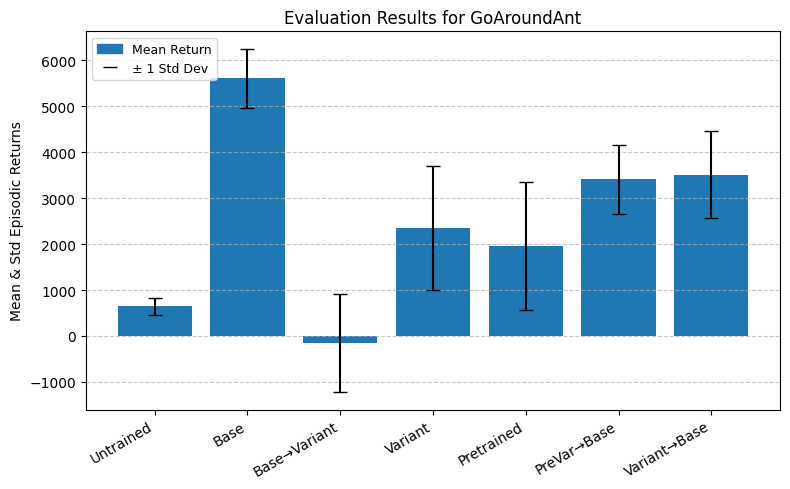

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

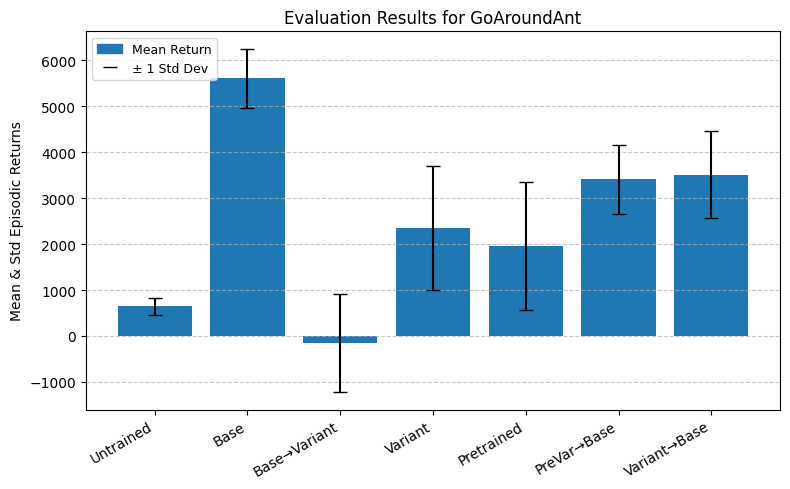

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#GoAround
'''BaseAnt model run on GoAroundAnt Env'''
BaseToGoAround_returns = evaluate(models=BaseAnt_model, env_id=GoAroundAnt, eval_episodes=episodes, env_xml=GoAroundAnt_xml)
'''GoAroundAnt model Eval'''
GoAroundAnt_returns = evaluate(models=GoAround_models, env_id=GoAroundAnt, eval_episodes=episodes, env_xml=GoAroundAnt_xml)
'''Pretrained GoAroundAnt model Eval'''
Pretrain_GoAroundAnt_returns = evaluate(models=Pretrain_GoAround_models, env_id=GoAroundAnt, eval_episodes=episodes, env_xml=GoAroundAnt_xml)
'''Pretrained GoAroundAnt model run on BaseAnt Env'''
PreGoAroundToBase_returns = evaluate(models=Pretrain_GoAround_models, env_id=BaseAnt, eval_episodes=episodes)
'''GoAroundAnt model run on BaseAnt Env'''
GoAroundToBase_returns = evaluate(models=GoAround_models, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "GoAroundAnt": {
        "Base→Variant": compute_stats(BaseToGoAround_returns),
        "Variant": compute_stats(GoAroundAnt_returns),
        "Pretrained": compute_stats(Pretrain_GoAroundAnt_returns),
        "PreVar→Base": compute_stats(PreGoAroundToBase_returns),
        "Variant→Base": compute_stats(GoAroundToBase_returns),
    }
}

plot_grouped_barcharts(results)

Mean: 644.8153142339935, Std: 188.27885484893034
Mean: 5607.196554604944, Std: 650.9554476428688
Mean: 683.7411506696689, Std: 609.8043719147546
Mean: 3249.8235925268773, Std: 1182.6627740467886
Mean: 4769.471637376655, Std: 1007.2751880151743
Mean: 3347.5955068820535, Std: 1102.354718523758
Mean: 2945.4250869472758, Std: 965.4417412865129
Mean: 644.8153142339935, Std: 188.27885484893034
Mean: 5607.196554604944, Std: 650.9554476428688
Mean: 683.7411506696689, Std: 609.8043719147546
Mean: 3249.8235925268773, Std: 1182.6627740467886
Mean: 4769.471637376655, Std: 1007.2751880151743
Mean: 3347.5955068820535, Std: 1102.354718523758
Mean: 2945.4250869472758, Std: 965.4417412865129


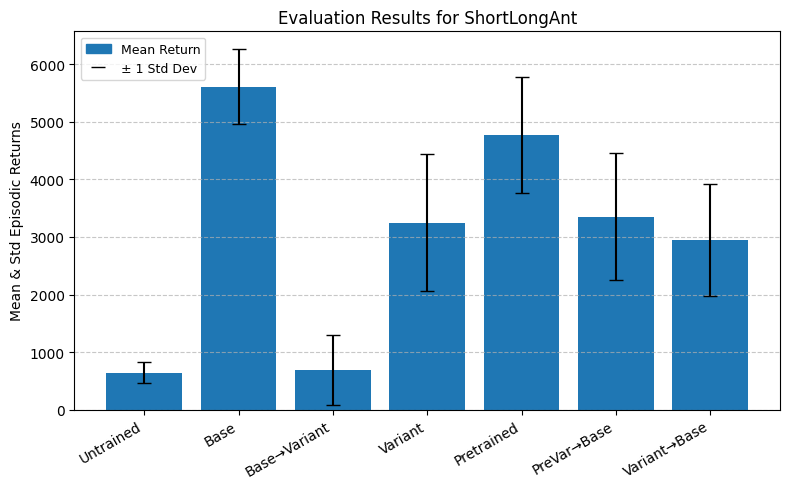

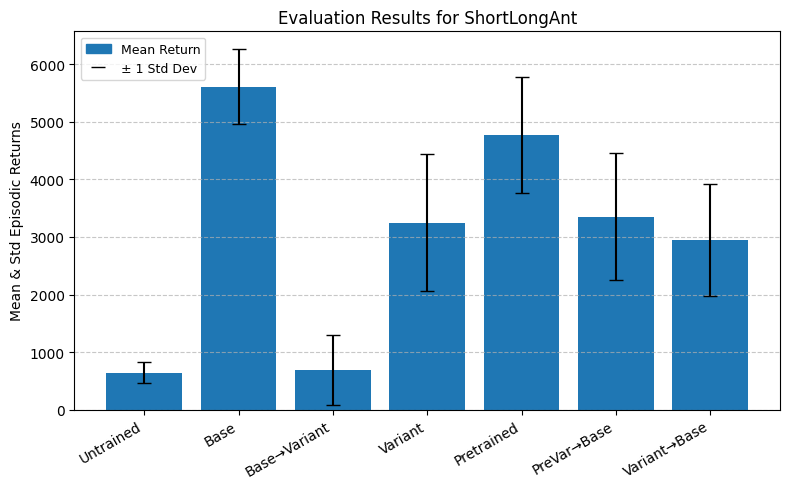

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#ShortLong
'''BaseAnt model run on ShortLongAnt Env'''
BaseToShortLong_returns = evaluate(models=BaseAnt_model, env_id=ShortLongAnt, eval_episodes=episodes, env_xml=ShortLongAnt_xml)
'''ShortLongAnt model Eval'''
ShortLongAnt_returns = evaluate(models=ShortLong_models, env_id=ShortLongAnt, eval_episodes=episodes, env_xml=ShortLongAnt_xml)
'''Pretrained ShortLongAnt model Eval'''
Pretrain_ShortLongAnt_returns = evaluate(models=Pretrain_ShortLong_models, env_id=ShortLongAnt, eval_episodes=episodes, env_xml=ShortLongAnt_xml)
'''Pretrained ShortLongAnt model run on BaseAnt Env'''
PreShortLongToBase_returns = evaluate(models=Pretrain_ShortLong_models, env_id=BaseAnt, eval_episodes=episodes)
'''ShortLongAnt model run on BaseAnt Env'''
ShortLongToBase_returns = evaluate(models=ShortLong_models, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "ShortLongAnt": {
        "Base→Variant": compute_stats(BaseToShortLong_returns),
        "Variant": compute_stats(ShortLongAnt_returns),
        "Pretrained": compute_stats(Pretrain_ShortLongAnt_returns),
        "PreVar→Base": compute_stats(PreShortLongToBase_returns),
        "Variant→Base": compute_stats(ShortLongToBase_returns),
    }
}

plot_grouped_barcharts(results)

In [ ]:
def stats_check(mean_A, std_A, mean_B, std_B):

    # num samples
    n_A = n_B = 500

    # t-test
    t_stat, p_value = ttest_ind_from_stats(mean1=mean_A, std1=std_A, nobs1=n_A,
                                           mean2=mean_B, std2=std_B, nobs2=n_B,
                                           equal_var=False)

    diff_means = mean_A - mean_B

    # se
    se_A = std_A**2 / n_A
    se_B = std_B**2 / n_B
    se_AB = sqrt(se_A + se_B)

    # df adjusts for std
    numerator = (se_A + se_B) ** 2
    denominator = ((se_A**2) / (n_A - 1)) + ((se_B**2) / (n_B - 1))
    df = numerator / denominator

    # 95% Confidence Interval
    alpha = 0.05
    t_crit = t.ppf(1 - alpha/2, df)
    margin = t_crit * se_AB
    ci_low = diff_means - margin
    ci_high = diff_means + margin

    # calc %
    percent_diff = (diff_means / mean_B) * 100
    ci_low_percent = (ci_low / mean_B) * 100
    ci_high_percent = (ci_high / mean_B) * 100

    print(f"Mean A: {mean_A}, Mean B: {mean_B}")
    print(f"Difference in means: {diff_means}")
    print(f"Percentage difference: {percent_diff}%")
    print(f"95% CI: [{ci_low}, {ci_high}]")
    print(f"95% CI in percentage difference: [{ci_low_percent}%, {ci_high_percent}%]")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value:}")
    print(f"alpha: {alpha}")

In [ ]:
#ClimberAnt
print("ClimberAnt \n\nprevar vs var:")
stats_prevarvsvar = stats_check(2985.76, 1373.65, 3254.68, 1190.69)

print("\nprevar vs var on Base Env:")
stats_prevarvsvar_base = stats_check(3878.96, 1438.61, 4007.02, 1167.40)

#GoAroundAnt
print("\nGoAroundAnt \n\nprevar vs var:")
stats_prevarvsvar = stats_check(1955.56, 1387.56, 2354.80, 1347.36 )

print("\nprevar vs var on Base Env:")
stats_prevarvsvar_base = stats_check(3414.16, 752.71, 3513.58, 954.07 )

#ShortLongAnt
print("\nShortLongAnt \n\nprevar vs var:")
stats_prevarvsvar = stats_check(4769.47, 1007.28, 3249.82, 1182.66)

print("\nprevar vs var on Base Env:")
stats_prevarvsvar_base = stats_check(3347.60, 1102.35, 2945.43, 965.44)


ClimberAnt 

prevar vs var:
Mean A: 2985.76, Mean B: 3254.68
Difference in means: -268.9199999999996
Percentage difference: -8.262563447097707%
95% CI: [-428.45792136056946, -109.38207863942975]
95% CI in percentage difference: [-13.164363973126989%, -3.3607629210684236%]
t-statistic: -3.307843164806569
p-value: 0.000974429627665072
alpha: 0.05

prevar vs var on Base Env:
Mean A: 3878.96, Mean B: 4007.02
Difference in means: -128.05999999999995
Percentage difference: -3.1958912109248256%
95% CI: [-290.6570907907932, 34.537090790793314]
95% CI in percentage difference: [-7.253697031479583%, 0.8619146096299324%]
t-statistic: -1.5456038587641925
p-value: 0.12253072978558033
alpha: 0.05

GoAroundAnt 

prevar vs var:
Mean A: 1955.56, Mean B: 2354.8
Difference in means: -399.24000000000024
Percentage difference: -16.954306098182446%
95% CI: [-568.9733179763139, -229.5066820236866]
95% CI in percentage difference: [-24.162277814519868%, -9.746334381845022%]
t-statistic: -4.6157524536327506
p-